Chinese Word Emedding

In [2]:
# first install wget 
!pip install wget

  Using cached wget-3.2.zip (10 kB)
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=9ca86404978e3da399637d9f80e77ebd7647ccf15e1acc224e6140c6fd17dbd8
  Stored in directory: /Users/randgrant/Library/Caches/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
# Calculation
import numpy as np
import re

# Chinese NLP
import jieba
import stopwordsiso
from stopwordsiso import stopwords

# Showing Result
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE

# Word Vector
import nltk
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import Word2Vec
import codecs

In [4]:
#Run this every time you run the notebook (if working on your own computer)
embeddings_file = "sgns.weibo.word.bz2"
#This line will load the 200,000 most common words into wv, a variable of word vectors
#Note that this will load these into memory, so if you don't have a lot of memory on your computer you may run into problems/slowness
wv = KeyedVectors.load_word2vec_format(embeddings_file, binary=False, limit=200000)

## Chinese Word Vector Examples

In [11]:
#View the actual value of a vector for a word:
# this is a 300-dimensional vector
print("Shape of a word vector: ")
print(np.shape(wv['language'])) #play around with other words
print("Word vector for '她们':")
print(wv['她们'])

Shape of a word vector: 
(300,)
Word vector for '她们':
[ 0.103229  0.262013  0.260333  0.256208  0.053925  0.029112  0.046635
  0.037861  0.048672  0.14674   0.235704  0.166753  0.009411 -0.012865
  0.010915  0.255409 -0.06188  -0.281446  0.676499 -0.238047  0.063596
 -0.06598   0.167279  0.104832  0.014178  0.093726 -0.016231  0.172963
  0.126681 -0.12017  -0.086508 -0.356151  0.265634 -0.166346 -0.049017
  0.079614  0.009738 -0.069898 -0.551576  0.134538 -0.138498 -0.043751
 -0.115721  0.138382  0.445095 -0.209368  0.348714  0.05857  -0.215899
  0.163844 -0.206939  0.298285 -0.033482  0.192324  0.178568 -0.119193
 -0.047684  0.059463  0.039447 -0.233447 -0.174795  0.099283 -0.22532
 -0.224391  0.403765 -0.134041 -0.115816 -0.296303  0.376629  0.013709
 -0.051973 -0.096273  0.317882  0.058543  0.186186 -0.094611  0.185952
  0.240657 -0.057203  0.115495 -0.151155  0.072935  0.132072  0.017737
  0.193661  0.12266   0.270064  0.009574 -0.240214 -0.164152  0.033018
  0.271672  0.13189   0.

In [12]:
#We can compare words by computing their cosine similarity
# Try this out for different word pairs:
print(wv.similarity('人', '动物'))
print(wv.similarity('人', '男士'))
print(wv.similarity('人', '女士'))

0.17915054
0.17841144
0.16730349


In [16]:
# Look for most similar words to a given word
#Try this out for different words
wv.most_similar(positive=['人'])

[('中国人', 0.45035773515701294),
 ('令人同情', 0.438035786151886),
 ('不跟人', 0.42575734853744507),
 ('丑人俊', 0.4257080852985382),
 ('得人', 0.41410529613494873),
 ('曾让我', 0.4113842248916626),
 ('低三下四', 0.41079458594322205),
 ('都是人', 0.4102144241333008),
 ('人心叵测', 0.4101538062095642),
 ('数人', 0.40981408953666687)]

In [17]:
wv.most_similar(positive=['网购', '快递']) #Or maybe Camberwell?

[('4008111111', 0.6679229736328125),
 ('EMS', 0.6668504476547241),
 ('送货员', 0.6378894448280334),
 ('快递公司', 0.6275048851966858),
 ('申通', 0.6231832504272461),
 ('ems', 0.6225036382675171),
 ('运单', 0.6195290684700012),
 ('陆运', 0.6192419528961182),
 ('爆仓', 0.6125563979148865),
 ('平邮', 0.6107132434844971)]

In [18]:
wv.most_similar(positive=['淘宝', '京东']) #Or maybe Camberwell?

[('京东商城', 0.6866937279701233),
 ('易讯', 0.680483341217041),
 ('易迅网', 0.669683575630188),
 ('易迅', 0.6558387875556946),
 ('一淘', 0.6486860513687134),
 ('电器城', 0.6275861859321594),
 ('苏宁', 0.6251825094223022),
 ('苏宁国美', 0.6244820952415466),
 ('191亿', 0.6196848750114441),
 ('etao', 0.6134917140007019)]

## t-SNE (within corpus)

In [5]:
# Code referenced & edited from NLP-Week2.1-Lecture

def Chinese_tokeniser(doc):
    #Split on spaces
    tokens = jieba.lcut(doc)
    processed = []
    for t in tokens:
        #Remove Chinese stop words
        if not t in stopwords("zh"):
            processed = processed + [t]
    #Return an array of tokens for that document
    return processed

In [6]:
font_path = "SourceHanSansCN-Normal.otf"
prop = fm.FontProperties(fname = font_path)

In [8]:
# From https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontproperties=prop,
                     size=14)
    plt.show()

In [10]:
#Read back in
file_name = "DOUBAN_dataset_group02"
post_df = pd.read_csv(file_name + ".tsv",sep = "\t", usecols = ["title","link","main text","reply text"])

douban_all_text = []
for index in range(len(post_df)):
    #add title
    all_text = "" + str(post_df.iloc[index][0])
    #add main text
    for main in post_df.iloc[index][2]:
        all_text = all_text + str(main)
    for reply in post_df.iloc[index][3]:
        all_text = all_text + str(reply)
    douban_all_text.append(all_text)

In [11]:
douban_all_text_token = []
for every_post in douban_all_text:
    douban_all_text_token.append(Chinese_tokeniser(every_post))
douban_all_text_token

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/r1/zv_cgpdj61b8c60j_yk8lx900000gn/T/jieba.cache
Loading model cost 0.624 seconds.
Prefix dict has been built successfully.


[['PUA',
  '这件',
  '事',
  '母亲',
  '当仁不让',
  '[',
  "'",
  'PUA',
  '这件',
  '事',
  '母亲',
  '当仁不让',
  '\\',
  'n',
  '\\',
  'n',
  '放假',
  '一起',
  '总共',
  '两三天',
  '好不容易',
  '鼓起勇气',
  '战胜',
  '外貌',
  '焦虑',
  '身材',
  '焦虑',
  '全都',
  '扑',
  '回',
  '身上',
  '\\',
  'n',
  '包括',
  '限于',
  '每天',
  '三次',
  '惊讶',
  '“',
  '看看',
  'xx',
  '身体',
  '部位',
  '肥',
  '”',
  '每天',
  '三次',
  '嫌弃',
  '“',
  '胖成',
  '鬼样',
  '”',
  '每天',
  '无数次',
  '感叹',
  '责怪',
  '“',
  '脸',
  '”',
  '“',
  '脸',
  '变成',
  '样子',
  '”',
  '“',
  '能长',
  '痘痘',
  '”',
  '“',
  '脸',
  '真的',
  '想想',
  '办法',
  '”',
  '偶发性',
  '总结',
  '“',
  '现在',
  '全毁',
  '”',
  '\\',
  'n',
  '\\',
  'n',
  '今晚',
  '逛街',
  '买',
  '衣服',
  '“',
  '知道',
  '里面',
  '干什么',
  '磨蹭',
  '”',
  '“',
  '胖',
  '穿',
  '进去',
  '大码',
  'XL',
  '”',
  '“',
  '别试',
  '丑死',
  '”',
  '“',
  '真的',
  '好丑',
  '”',
  '“',
  '别买',
  '衣服',
  '减',
  '完肥',
  '买',
  '”',
  '…',
  '…',
  '场景',
  '采用',
  '极',
  '嫌弃',
  '极不耐',
  '极',
  '厌恶',
  '表情',
  '语气',
  '形成',
  '鲜明对比',

In [19]:
model = Word2Vec(douban_all_text_token, workers=4, vector_size=300, min_count=5, window=10, sample=1e-3)

In [20]:
len(model.wv) #vocab size

57

/Users/randgrant/opt/anaconda3/envs/nlpminiproject/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/randgrant/opt/anaconda3/envs/nlpminiproject/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


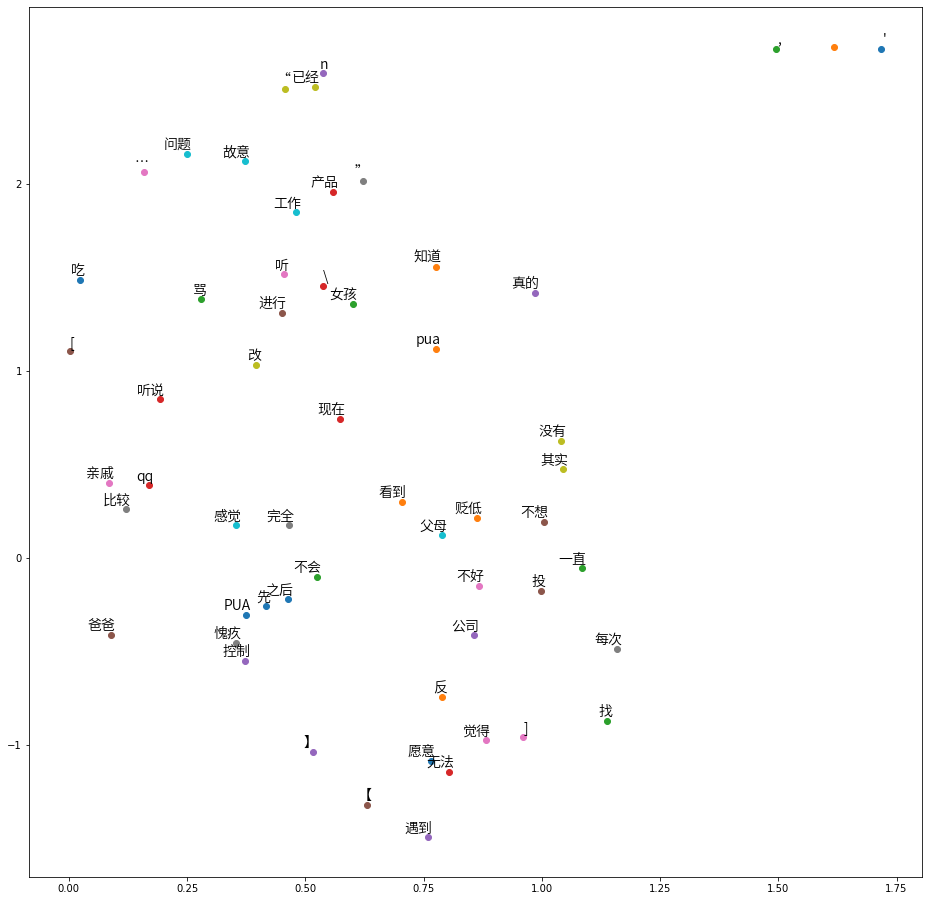

In [21]:
# Plot the tSNE!
tsne_plot(model)

## t-SNE within Chinese Word Embeddings

In [22]:
wv_model = []

for post_token in douban_all_text_token:
    for word in post_token:
        if word not in wv_model:
            wv_model.append(word)

In [23]:
len(wv_model)

1156

In [26]:
# Modified for existing Chinese Word Embeddings

# From https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot_modified(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in wv_model:
        if word in wv.index_to_key:
            tokens.append(wv[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontproperties=prop,
                     size=10)
    plt.show()

/Users/randgrant/opt/anaconda3/envs/nlpminiproject/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/randgrant/opt/anaconda3/envs/nlpminiproject/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


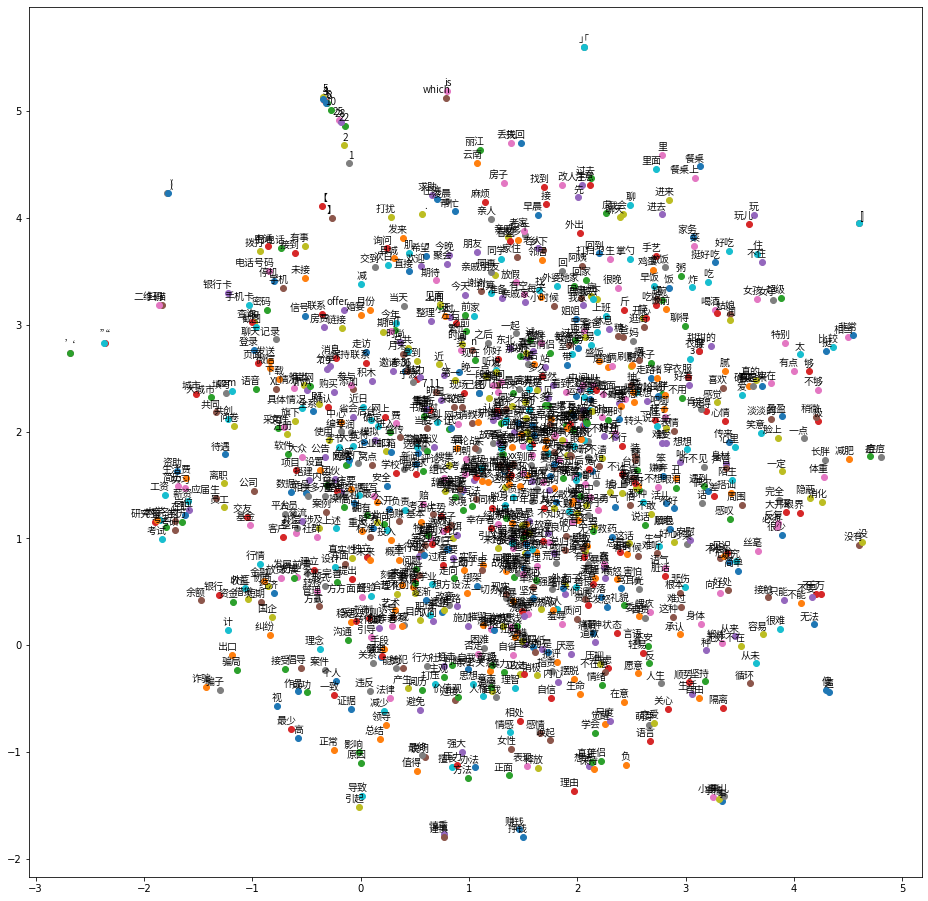

In [27]:
tsne_plot_modified(wv_model)